# Импорт

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

from joblib import dump


# Загружаем датасет и разбиваем её на выборку.

In [3]:
data = pd.read_csv('../Data/data_for_train.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('hazardous', axis=1), data['hazardous'], test_size=0.25, random_state=42)
X_train.shape


(119916, 4)

# Создание модели

In [4]:
model_class = tf.keras.models.Sequential()
model_class.add(tf.keras.layers.Dense(X_train.shape[1],
                                      activation='sigmoid',
                                      input_shape=(X_train.shape[1],), 
                                      name='input',
                                      # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
                                      #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
                                      # bias_initializer=tf.keras.initializers.HeNormal,
                                      use_bias=True
                                      ))
model_class.add(tf.keras.layers.Dense(X_train.shape[1]*2,
                                      activation='sigmoid',
                                      name='hidden_layer_2',
                                      # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
                                      #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
                                      # bias_initializer=tf.keras.initializers.HeNormal,
                                      use_bias=True
                                      ))
model_class.add(tf.keras.layers.Dense(X_train.shape[1],
                                      activation='sigmoid',
                                      name='hidden_layer_3',
                                      # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
                                      #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
                                      # bias_initializer=tf.keras.initializers.HeNormal,
                                      use_bias=True
                                      ))
model_class.add(tf.keras.layers.Dense(1,
                                      name='output', 
                                      activation='sigmoid',
                                      # kernel_regularizer=tf.keras.regularizers.L2(l2=1), 
                                    #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
                                      # bias_initializer=tf.keras.initializers.HeNormal,
                                      use_bias=True
                                      ))
model_class.summary()
model_coder = model_class


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 4)                 20        
                                                                 
 hidden_layer_2 (Dense)      (None, 8)                 40        
                                                                 
 hidden_layer_3 (Dense)      (None, 4)                 36        
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [104]:
# model_coder = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(3, input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(1,)
# ])


## Компиляция

In [5]:
model_coder.compile(
    optimizer='Adam',
    loss='mse',
    metrics=['binary_crossentropy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Recall()]
)


# Обучение

In [6]:
model_coder.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    validation_split=0.5,
    epochs=10,
    batch_size=10
)


Epoch 1/10
5996/5996 [==============================] - 14s 2ms/step - loss: 0.2482 - binary_crossentropy: 0.6897 - false_negatives: 6506.0000 - recall: 0.7830 - val_loss: 0.2331 - val_binary_crossentropy: 0.6591 - val_false_negatives: 3217.0000 - val_recall: 0.8922
Epoch 2/10
5996/5996 [==============================] - 13s 2ms/step - loss: 0.1907 - binary_crossentropy: 0.5695 - false_negatives: 5327.0000 - recall: 0.8223 - val_loss: 0.1594 - val_binary_crossentropy: 0.4985 - val_false_negatives: 4065.0000 - val_recall: 0.8638
Epoch 3/10
5996/5996 [==============================] - 13s 2ms/step - loss: 0.1458 - binary_crossentropy: 0.4631 - false_negatives: 2955.0000 - recall: 0.9014 - val_loss: 0.1322 - val_binary_crossentropy: 0.4279 - val_false_negatives: 1598.0000 - val_recall: 0.9465
Epoch 4/10
5996/5996 [==============================] - 13s 2ms/step - loss: 0.1270 - binary_crossentropy: 0.4109 - false_negatives: 1339.0000 - recall: 0.9553 - val_loss: 0.1198 - val_binary_crossen

# Predict

In [7]:
y_predicted = model_coder.predict(X_test).T[0]


1250/1250 [==============================] - 1s 966us/step


In [8]:
np.unique(y_predicted)


array([0.01553766, 0.01553791, 0.01553835, ..., 0.8568084 , 0.8568128 ,
       0.8568154 ], dtype=float32)

# Оценка качества 

In [9]:
print('Accuracy')
print(accuracy_score(y_test, y_predicted>0.5))


Accuracy
0.871985389772841


In [10]:
print('Confusion matrix')
print(confusion_matrix(y_test, y_predicted > 0.5))


Confusion matrix
[[14825  5026]
 [   91 20030]]


In [11]:
print('Precision, Recall, F\n', classification_report(y_test, y_predicted > 0.5))


Precision, Recall, F
               precision    recall  f1-score   support

       False       0.99      0.75      0.85     19851
        True       0.80      1.00      0.89     20121

    accuracy                           0.87     39972
   macro avg       0.90      0.87      0.87     39972
weighted avg       0.90      0.87      0.87     39972



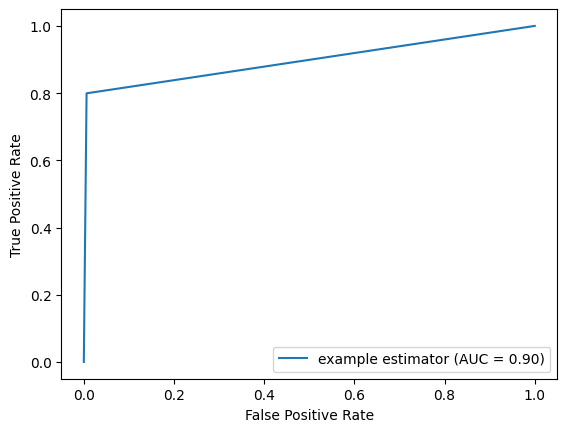

In [12]:
fpr, tpr, thresholds = roc_curve(y_predicted > 0.5, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

In [13]:
with open('../Models/Perceptron.sav', 'wb') as handle:
    b = dump(model_coder, handle)
